In [25]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix ,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import json



In [26]:
# Load the dataset
df = pd.read_csv('tmdb_5000_movies.csv')  # Replace with your file path if needed
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [27]:
# Data Cleaning
# Drop rows with missing revenue or budget, and filter out zero values
df = df.dropna(subset=['revenue', 'budget'])
df = df[(df['revenue'] > 0) & (df['budget'] > 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3229 entries, 0 to 4798
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3229 non-null   int64  
 1   genres                3229 non-null   object 
 2   homepage              1347 non-null   object 
 3   id                    3229 non-null   int64  
 4   keywords              3229 non-null   object 
 5   original_language     3229 non-null   object 
 6   original_title        3229 non-null   object 
 7   overview              3229 non-null   object 
 8   popularity            3229 non-null   float64
 9   production_companies  3229 non-null   object 
 10  production_countries  3229 non-null   object 
 11  release_date          3229 non-null   object 
 12  revenue               3229 non-null   int64  
 13  runtime               3229 non-null   float64
 14  spoken_languages      3229 non-null   object 
 15  status                3229

In [ ]:
# Select relevant features
features = ['budget', 'popularity', 'runtime', 'vote_average', 'genres', 'keywords']
df = df[features + ['revenue']]



In [8]:
# Handle missing runtime and vote_average with median
df['runtime'].fillna(df['runtime'].median(), inplace=True)
df['vote_average'].fillna(df['vote_average'].median(), inplace=True)



/tmp/ipykernel_2399/1698672650.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['runtime'].fillna(df['runtime'].median(), inplace=True)
/tmp/ipykernel_2399/1698672650.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [11]:
# Parse JSON-like strings in 'genres' and 'keywords'
def parse_json(column):
    return column.apply(lambda x: [item['name'] for item in json.loads(x)] if pd.notnull(x) else [])



In [12]:
df['genres'] = parse_json(df['genres'])
df['keywords'] = parse_json(df['keywords'])



In [13]:
# Vectorize genres and keywords using MultiLabelBinarizer
mlb_genres = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb_genres.fit_transform(df['genres']), 
                              columns=mlb_genres.classes_, 
                              index=df.index)

mlb_keywords = MultiLabelBinarizer()
keywords_encoded = pd.DataFrame(mlb_keywords.fit_transform(df['keywords']), 
                                columns=mlb_keywords.classes_, 
                                index=df.index)



In [14]:
# Limit keywords to top 20 most frequent to reduce dimensionality
top_keywords = keywords_encoded.sum().sort_values(ascending=False).head(20).index
keywords_encoded = keywords_encoded[top_keywords]



In [31]:
# Combine numeric features with encoded text features
X = pd.concat([df[['budget', 'popularity', 'runtime', 'vote_average']], 
               genres_encoded, keywords_encoded], axis=1)
y = df['revenue']
X.info()



<class 'pandas.core.frame.DataFrame'>
Index: 3229 entries, 0 to 4798
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3229 non-null   int64  
 1   popularity            3229 non-null   float64
 2   runtime               3229 non-null   float64
 3   vote_average          3229 non-null   float64
 4   Action                3229 non-null   int64  
 5   Adventure             3229 non-null   int64  
 6   Animation             3229 non-null   int64  
 7   Comedy                3229 non-null   int64  
 8   Crime                 3229 non-null   int64  
 9   Documentary           3229 non-null   int64  
 10  Drama                 3229 non-null   int64  
 11  Family                3229 non-null   int64  
 12  Fantasy               3229 non-null   int64  
 13  Foreign               3229 non-null   int64  
 14  History               3229 non-null   int64  
 15  Horror                3229

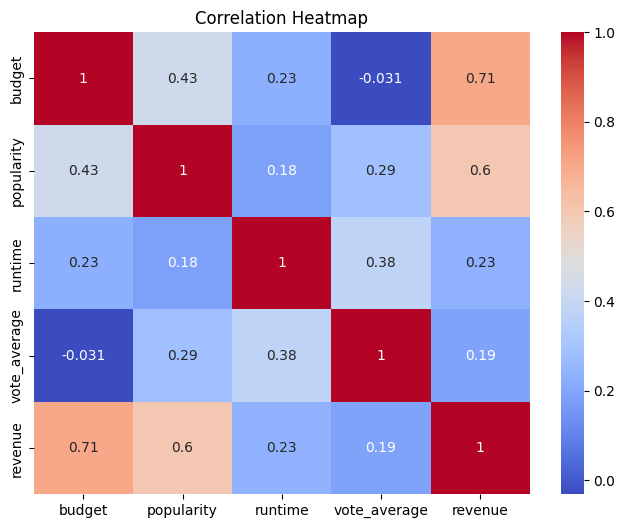

In [30]:
# Exploratory Data Analysis (EDA)
# Correlation heatmap for numeric features
plt.figure(figsize=(8, 6))
sns.heatmap(df[['budget', 'popularity', 'runtime', 'vote_average', 'revenue']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')  # Save for presentation
plt.show()



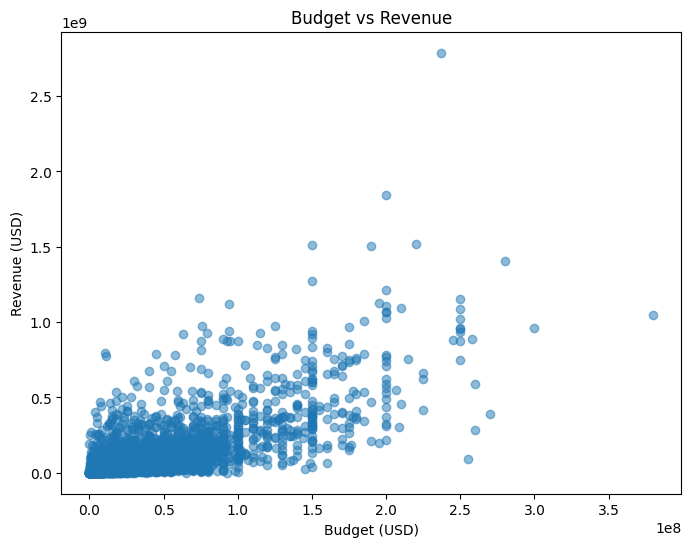

In [16]:
# Scatter plot: Budget vs Revenue
plt.figure(figsize=(8, 6))
plt.scatter(df['budget'], df['revenue'], alpha=0.5)
plt.xlabel('Budget (USD)')
plt.ylabel('Revenue (USD)')
plt.title('Budget vs Revenue')
plt.savefig('budget_vs_revenue.png')  # Save for presentation
plt.show()



Text(0.5, 1.0, 'Popularity vs. Revenue')

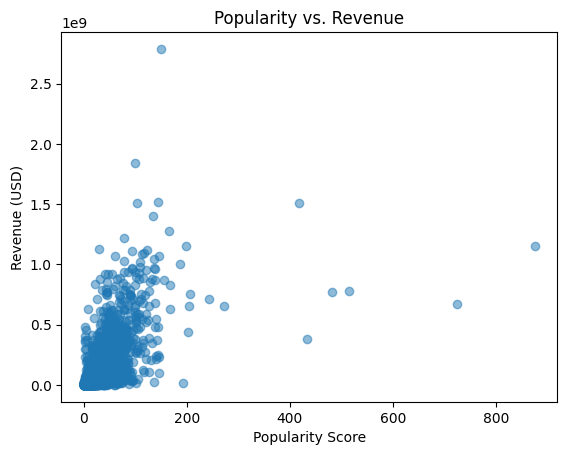

In [24]:
plt.scatter(df['popularity'], df['revenue'], alpha=0.5)

plt.xlabel('Popularity Score')
plt.ylabel('Revenue (USD)')
plt.title('Popularity vs. Revenue')

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [18]:
# Fit Multiple Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

In [19]:
# Predictions
y_pred = model.predict(X_test)



In [20]:
# Model Evaluation
print(f'R-squared: {r2_score(y_test, y_pred):.3f}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')



R-squared: 0.572
Root Mean Squared Error: 147002543.00


In [ ]:
# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coef_df.sort_values(by='Coefficient', ascending=False).head(10))  # Top 10 coefficients



                 Feature   Coefficient
33                sequel  6.308262e+07
23  duringcreditsstinger  3.249487e+07
3           vote_average  2.964703e+07
11                Family  2.896463e+07
5              Adventure  1.736846e+07
15                Horror  1.659655e+07
18               Romance  1.414901e+07
38              teenager  1.135080e+07
25        woman director  8.144471e+06
36            friendship  7.705083e+06


In [33]:
coef_df.sort_values(by="Coefficient")

,Feature,Coefficient
28,dystopia,-6.979800e+07
22,Western,-5.187162e+07
14,History,-2.748235e+07
10,Drama,-2.609651e+07
39,alien,-1.935215e+07
34,sport,-1.915721e+07
21,War,-1.884174e+07
8,Crime,-1.396374e+07
35,biography,-1.341354e+07
24,based on novel,-1.232807e+07


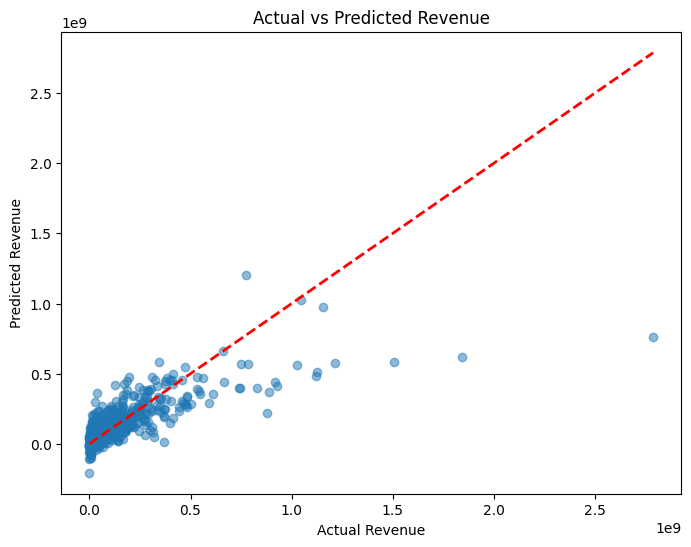

In [40]:
# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.savefig('actual_vs_predicted.png')  # Save for presentation
plt.show()